In [1]:
import os
import numpy as np
import pandas as pd
import igraph as ig
import phenograph
import seaborn as sns
import scanpy as sc
from utils import *
import anndata

## data visualization

### load in preprocessed data with annotated metaclusters

In [2]:
resolution = 1.25   
sample_id = 'A5248' #'LT-ART
timepoint_label = 'day' #'month'

adata_subsample = sc.read_h5ad(os.path.join('data','adata',f'{sample_id}_subsample.h5ad'))

functional_markers = ['PD-1','Bcl-2','Ki-67','CCR5','HLA-DR','CD57','CD38','CD127']

phenotypic_markers = ['CD45', 'CD19', 'CD3','CD4','CD8', 'CD14','CD56','CD16','CD11c','TCRgd',
                    'CD45RA','CCR10','CD28','CD27','CD95','CCR7','CD99','CD127','CD31','FoxP3',
                    'CCR4','CCR6','CXCR5','CXCR3', 'CD25']

if sample_id == 'LT-ART':
    phenotypic_markers.remove('CD31')

#create dataframe for analysis/plotting
data = pd.DataFrame(adata_subsample.X, columns = adata_subsample.var_names, index = adata_subsample.obs_names)
data['sample_id'] = adata_subsample.obs['fcs_file'].copy()
data['timepoint'] = adata_subsample.obs['timepoint'].copy()
data['patient_id'] = adata_subsample.obs['patient_id'].copy()
data['cluster_label'] = adata_subsample.obs[f'phenograph_clusters_res{resolution}'].copy()
data[f'phenograph_metaclusters_res{resolution}_labeled'] = adata_subsample.obs[f'phenograph_metaclusters_res{resolution}_labeled'].values

#### UMAP visualization

/Users/jolene/opt/miniconda3/envs/venv_FCS/lib/python3.9/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
... storing 'patient_id' as categorical


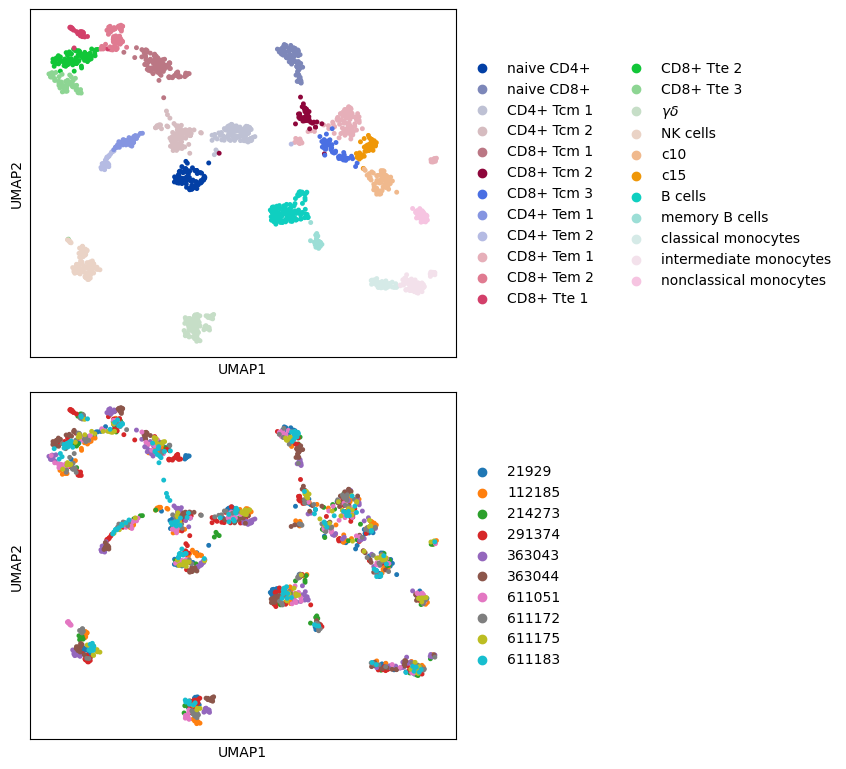

In [3]:
#plot UMAP of metaclusters
centroids = data.groupby(['sample_id', 'cluster_label'])[phenotypic_markers].median().fillna(0).reset_index()
centroids = centroids.merge(cluster_size(sample_n(data=data,
                                                sample_label='sample_id'),
                                        cluster_n(data=data,
                                                    sample_label='sample_id',
                                                    cluster_label='cluster_label')))

centroids = label_centroids(data=data,
                                centroids=centroids,
                                sample_label='sample_id',
                                cluster_label='cluster_label',
                                target_label=f'phenograph_metaclusters_res{resolution}_labeled')

adata_c = anndata.AnnData(centroids.drop(columns = ['sample_id', 'cluster_label', f'phenograph_metaclusters_res{resolution}_labeled', 'cluster_n', 'sample_n', 'cluster_size']))
adata_c.obs['sample_id'] = centroids['sample_id'].values
adata_c.obs['cluster_label'] = centroids['cluster_label'].values
adata_c.obs[f'phenograph_metaclusters_res{resolution}_labeled'] = centroids[f'phenograph_metaclusters_res{resolution}_labeled'].values
adata_c.obs['patient_id'] = [i.split('_')[1] for i in adata_c.obs['sample_id']]

sc.pp.neighbors(adata_c, n_neighbors= 30)
sc.tl.umap(adata_c)

color_ids = [f'phenograph_metaclusters_res{resolution}_labeled', 'patient_id']
fig, axes = plt.subplots(len(color_ids), 1, figsize = (5.5, 10), gridspec_kw={'hspace': 0.1, 'wspace': 0.15, 'bottom':0.15})
for i, ax in zip(range(0, len(color_ids)), axes.flat):
    sc.pl.umap(adata_c, color = color_ids[i], s = 50, ax = ax, title = '', show = False)

#### heatmap

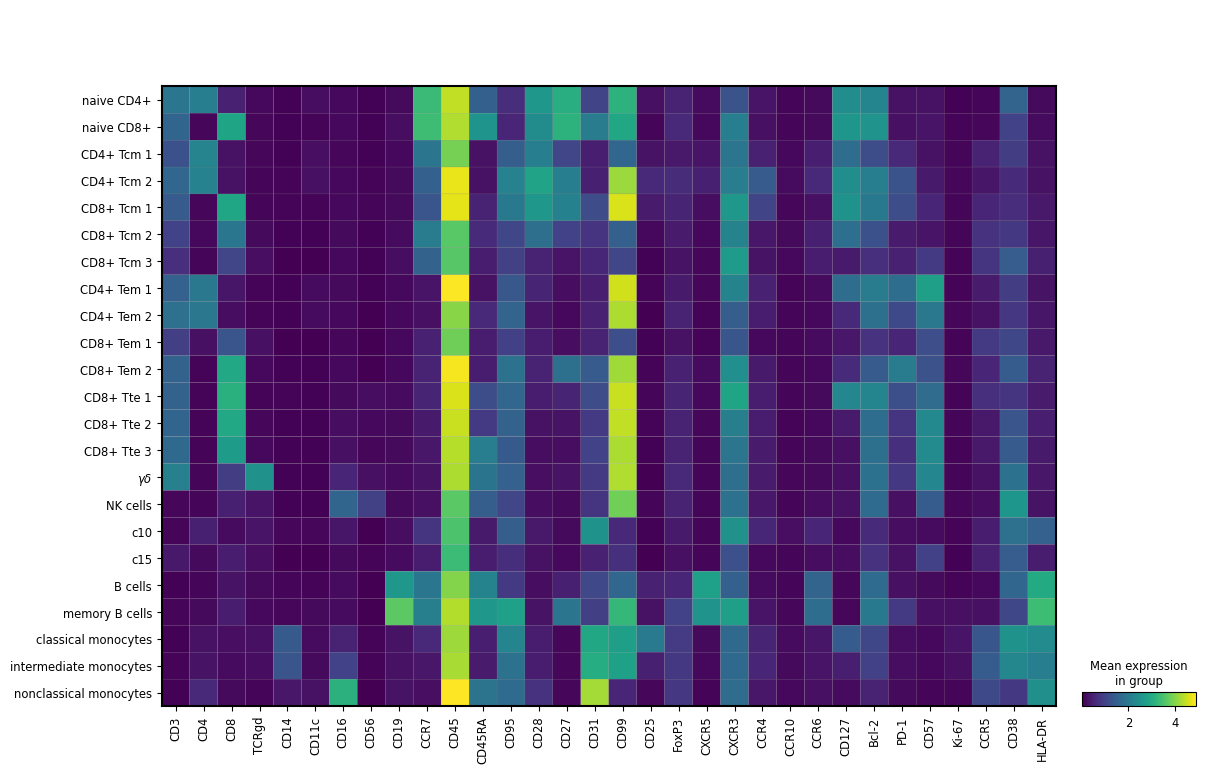

In [4]:
#plot heatmap of marker expression per metaclusters
feature_order = ['CD3', 'CD4', 'CD8', 'TCRgd','CD14', 'CD11c', 'CD16', 'CD56', 'CD19', 'CCR7', 'CD45', 'CD45RA', 'CD95',
                'CD28', 'CD27','CD31', 'CD99', 'CD25', 'FoxP3', 'CXCR5', 'CXCR3', 'CCR4', 'CCR10', 'CCR6', 'CD127', 'Bcl-2', 'PD-1', 'CD57', 'Ki-67', 'CCR5', 'CD38', 'HLA-DR']
sc.pl.matrixplot(adata_subsample, var_names = feature_order, groupby = f'phenograph_metaclusters_res{resolution}_labeled')

## perform elastic net regression

#### feature engineering and prediction

In [ ]:
#engineer features and perform prediction
engineered_feats = engineer_features(data, f'phenograph_metaclusters_res{resolution}_labeled', functional_markers = functional_markers, time_label = timepoint_label, patient_label = 'patient_id')
prediction_coef, scores = elastic_net(engineered_feats, timepoint_label = timepoint_label)

In [ ]:
#return non-zero coefficients that don't change direction of magnitude
coef = prediction_coef.fillna(0)

bar_df_mean = pd.DataFrame(coef.mean(1))

pos2neg_keep = np.where((coef.mean(1) > 0) & (coef.mean(1) - coef.std(1) > 0))[0]
neg2pos_keep = np.where((coef.mean(1) < 0) & (coef.mean(1) + coef.std(1) < 0))[0]

change_sign = np.concatenate([pos2neg_keep, neg2pos_keep])

bar_df_mean = bar_df_mean.iloc[change_sign]
index = coef.mean(1) != 0

bar_df_mean = bar_df_mean[index]
bar_df_mean = bar_df_mean[coef.mean(1) != 0]
bar_df_mean = bar_df_mean.sort_values(0, ascending = False)

sort_index = np.asarray(bar_df_mean.index)

bar_df = pd.DataFrame(coef)
bar_df = bar_df.loc[sort_index, :]
bar_df.columns = np.arange(0,10,1)
bar_df.shape

#### plot coefficients

In [ ]:
#plot coefficients
sns.set_style('ticks')

#colors for plotting features
cell_colors_dict = dict(zip(adata_c.obs[f'phenograph_metaclusters_res{resolution}_labeled'].cat.categories, adata_c.uns[f'phenograph_metaclusters_res{resolution}_labeled_colors']))
filename_save = 'coefficients'

fig, axes = plt.subplots(1,1, figsize = (20, 6), gridspec_kw={'bottom':0.15}) #20 x 8

vmax = (bar_df.transpose().mean() + bar_df.transpose().std()).max()
vmin = (bar_df.transpose().mean() - bar_df.transpose().std()).min()

cell_types = [i.rsplit('_')[-1] for i in bar_df.index]
feature_type = [i.split('_')[0] if 'diff' not in i else i.split('_')[1] for i in bar_df.index]
bar_df_ = bar_df.copy()
bar_df_['cell_types'] = cell_types
bar_df_['feature_type'] = feature_type
bar_df_['index'] = bar_df_.index
bar_df_ = bar_df_.melt(id_vars=['cell_types', 'feature_type', 'index'])

sns.boxplot(x = 'index', y = 'value', data = bar_df_, palette= pd.Series(bar_df_['cell_types']).map(cell_colors_dict),ax = axes, fliersize=0)
sns.stripplot(x = 'index', y = 'value', data = bar_df_, palette= pd.Series(bar_df_['cell_types']).map(cell_colors_dict),ax = axes, edgecolor='black', linewidth = 1)
plt.axhline(0, c = 'k', linestyle='-', dashes=(5, 5))

axes.set_xticklabels(axes.get_xticklabels(), rotation=45, horizontalalignment='right')
axes.set_ylim([-60,30])
axes.tick_params(labelsize=16)
axes.set_xlabel('feature', fontsize = 18)
axes.set_ylabel('coefficient', fontsize = 18)
# plt.savefig(filename_save+'.pdf', bbox_inches="tight", dpi = 300)

#### plot features changing over time

In [ ]:
plot_features(feature_list = ['diff_Bcl-2_exp_B cells', 'diff_Bcl-2_exp_naive CD8+', 'CD38_exp_CD4+ Tcm 2', 'CD38_exp_$\gamma\delta$', 'diff_PD-1_exp_CD8+ Tem 2', 'diff_PD-1_exp_nonclassical monocytes'], feats = engineered_feats, hue = None, filename_save = 'features', time = 'day')